# Initialization

## Library installation (only first time and in a local setup)

In [ ]:
!pip install transformers

In [ ]:
!pip install datasets

In [ ]:
!pip install librosa

In [ ]:
!pip install soundfile

In [ ]:
!pip install --upgrade ipywidgets

## Import libraries

In [110]:
from transformers import AutoFeatureExtractor, ASTForAudioClassification, ASTModel
from datasets import load_dataset
import torch
from functools import reduce
from operator import mul
import math
import torch.nn as nn
import os
import librosa
from torch.utils.data import Dataset
import random
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from matplotlib import pyplot as plt

# Parametrizzazione esecuzione

In [111]:
user = "Francesco"
# user = "Aldo"
# user = "Giovanni"

folds_path_var = ""
audio_path_var = ""
checkpoint_path_var = ""
metric_path_var = ""
inference_audio_path_var = ""
inference_label_path_var = ""
if user == "Francesco":
    fold_path_var = "c:/Users/cerru/Desktop/TUT17/Fold"
    audio_path_var = "c:/Users/cerru/Desktop/TUT17/Audio"
    inference_audio_path_var = "c:/Users/cerru/Desktop/TUT17/Test/Audio"
    inference_label_path_var = "c:/Users/cerru/Desktop/TUT17/Test/Labels/label_ordered.txt"
    checkpoint_path_var = "c:/Users/cerru/Desktop/models_checkpoints"
    metric_path_var = "c:/Users/cerru/Desktop/Progetto-CCAI-Barca_Cerruto_Traina/Progetto/models_metrics"
elif user == "Aldo":
    fold_path_var = "E:/Magistrale/Dataset_Progetto_Cognitive/TUT17/labels"
    audio_path_var = "E:/Magistrale/Dataset_Progetto_Cognitive/TUT17/Audio"
    inference_audio_path_var = "E:/Magistrale/Dataset_Progetto_Cognitive/TUT17/Test/Audio"
    inference_label_path_var = "E:/Magistrale/Dataset_Progetto_Cognitive/TUT17/Test/labels/meta.txt"
    checkpoint_path_var = "E:/Magistrale/Dataset_Progetto_Cognitive/TUT17/models_checkpoints"
    metric_path_var = "C:/Users/aldob/Documents/GitHub/Progetto-CCAI-Barca_Cerruto_Traina/Progetto/models_metrics"
elif user == "Giovanni":
    fold_path_var = "C:/Users/giotr/Desktop/TUT17/Fold"
    audio_path_var = "C:/Users/giotr/Desktop/TUT17/Audio"
    inference_audio_path_var = "C:/Users/giotr/Desktop/TUT17/Test/Audio"
    inference_label_path_var = "C:/Users/giotr/Desktop/TUT17/Test/Labels/label_ordered.txt"
    checkpoint_path_var = "C:/Users/giotr/Desktop/TUT17/models_checkpoints"
    metric_path_var = "C:/Users/giotr/Desktop/Progetto-CCAI-Barca_Cerruto_Traina/Progetto/models_metrics"

# Import AST Pretrained and test

## Import dataset huggingface

In [112]:
# import huggingface test dataset
dataset_huggingface = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation", trust_remote_code=True)
dataset_huggingface = dataset_huggingface.sort("id")
sampling_rate = dataset_huggingface.features["audio"].sampling_rate

## Import AST huggingface

In [113]:
# ast feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

In [114]:
# ast audio classification model pretrained
ast_huggingface = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
ast_huggingface

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTSdpaAttention(
            (attention): ASTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
       

## Test pretrained model

In [115]:
# audio file is decoded on the fly
inputs = feature_extractor(dataset_huggingface[0]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")
# test model
with torch.no_grad():
    logits = ast_huggingface(**inputs).logits
predicted_class_ids = torch.argmax(logits, dim=-1).item()
predicted_label = ast_huggingface.config.id2label[predicted_class_ids]
print(predicted_label)
# compute loss - target_label is e.g. "down"
target_label = ast_huggingface.config.id2label[0]
inputs["labels"] = torch.tensor([ast_huggingface.config.label2id[target_label]])
loss = ast_huggingface(**inputs).loss
round(loss.item(), 2)

Speech


0.17

# Prompt Tuning

## Retrieve Output size

In [116]:
# ast transformers pretrained
ast_model = ASTModel.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
ast_model

ASTModel(
  (embeddings): ASTEmbeddings(
    (patch_embeddings): ASTPatchEmbeddings(
      (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ASTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ASTLayer(
        (attention): ASTSdpaAttention(
          (attention): ASTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ASTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ASTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

In [117]:
# retrieve output size
inputs = feature_extractor(dataset_huggingface[0]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")
with torch.no_grad():
    outputs = ast_model(**inputs)
last_hidden_states = outputs.last_hidden_state
list(last_hidden_states.shape)

[1, 1214, 768]

## Model and testing

In [118]:
class AST_PromptTuning(nn.Module):
    def __init__(self, prompt_tokens: int = 5, prompt_dropout: float = 0.0, prompt_type: str = 'deep'):
        super().__init__()
        # load AST model
        self.encoder = ASTModel.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
        # hidden_size = depth of the model
        self.classifier = nn.Sequential(
            nn.Linear(self.encoder.config.hidden_size, 384),
            nn.Linear(384, 15)
        )
        # freeze ast parameters
        for n, p in self.encoder.named_parameters():
            p.requires_grad = False
        # fine tuning? shallow prompt? deep prompt?
        self.prompt_type = prompt_type # "shallow" "deep" or None
        # add user tokens
        if prompt_type is not None:
            # prompt
            self.prompt_tokens = prompt_tokens  # number of prompted tokens
            self.prompt_dropout = nn.Dropout(prompt_dropout)
            self.prompt_dim = self.encoder.config.hidden_size
            # initiate prompt (random)
            val = math.sqrt(6. / float(3 * reduce(mul, (self.encoder.config.patch_size, self.encoder.config.patch_size), 1) + self.prompt_dim))
            # my vector of learnable parameters (how many (prompt_tokens) and dimension (prompt_dim))
            self.prompt_embeddings = nn.Parameter(torch.zeros(1, self.prompt_tokens, self.prompt_dim))
            # xavier_uniform initialization
            nn.init.uniform_(self.prompt_embeddings.data, -val, val)
            # add tokens in other layer
            if self.prompt_type == 'deep':
                self.total_d_layer = self.encoder.config.num_hidden_layers
                self.deep_prompt_embeddings = nn.Parameter(
                    # - 1 cause shallow already inserted
                    torch.zeros(self.total_d_layer-1, self.prompt_tokens, self.prompt_dim)
                )
                # xavier_uniform initialization
                nn.init.uniform_(self.deep_prompt_embeddings.data, -val, val)

    def train(self, mode=True):
        # set train status for this class: disable all but the prompt-related modules
        if mode:
            # training:
            self.encoder.eval()
            if self.prompt_type is not None:
              # enable dropout and batch normalization
                self.prompt_dropout.train()
        else:
            # eval:
            for module in self.children():
                module.train(mode)

    def incorporate_prompt(self, x, prompt_embeddings, n_prompt: int = 0):
        # x shape: (batch size, n_tokens, hidden_dim)
        # pompt_embeddings shape: (1, n_prompt, hidden_dim)
        B = x.shape[0]
        # peek the class token, add prompts, add sequence
        # concat prompts: (batch size, cls_token + n_prompt + n_patches, hidden_dim)
        x = torch.cat((
            x[:, :1, :],
            self.prompt_dropout(prompt_embeddings.expand(B, -1, -1)),
            x[:, (1+n_prompt):, :]
        ), dim=1)
        return x

    def forward_features(self, x):
        # go through the encoder embeddings
        x = self.encoder.embeddings(x)
        # add prompts
        x = self.incorporate_prompt(x, self.prompt_embeddings)
        if self.prompt_type == 'deep':
            # deep mode
            x = self.encoder.encoder.layer[0](x)[0]
            for i in range(1, self.total_d_layer):
                x = self.incorporate_prompt(x, self.deep_prompt_embeddings[i-1], self.prompt_tokens)
                x = self.encoder.encoder.layer[i](x)[0]
        else:
            # shallow mode
            x = self.encoder.encoder(x)["last_hidden_state"]
        x = self.encoder.layernorm(x)
        return x

    def forward(self, x):
        if self.prompt_type is not None:
            x = self.forward_features(x)[:, 0, :]
        else:
          # pass x, take the classification token
            x = self.encoder(x)["last_hidden_state"][:, 0, :]
        x = self.classifier(x)
        return x

In [119]:
ast_head_tuning = AST_PromptTuning(prompt_type=None)
# count number of parameters
print("AST params:", sum(p.numel() for p in ast_head_tuning.parameters()))
# count number of trainable parameters
print("Head fine-tuning:", sum(p.numel() for p in ast_head_tuning.parameters() if p.requires_grad))
ast_shallow_tuning = AST_PromptTuning(prompt_type='shallow')
# count number of trainable parameters
print("Shallow prompt-tuning:", sum(p.numel() for p in ast_shallow_tuning.parameters() if p.requires_grad))
ast_deep_tuning = AST_PromptTuning(prompt_type='deep')
# count number of trainable parameters
print("Deep prompt-tuning:", sum(p.numel() for p in ast_deep_tuning.parameters() if p.requires_grad))

AST params: 86488335
Head fine-tuning: 301071
Shallow prompt-tuning: 304911
Deep prompt-tuning: 347151


In [120]:
inputs = feature_extractor(dataset_huggingface[0]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")
with torch.no_grad():
    outputs = ast_head_tuning(inputs['input_values'])
predicted_class_ids = torch.argmax(outputs, dim=-1).item()
print(predicted_class_ids)
softmax = F.softmax(outputs, dim=1)
print(softmax)

14
tensor([[0.0458, 0.0700, 0.1016, 0.0303, 0.0599, 0.0928, 0.0518, 0.0462, 0.0469,
         0.0331, 0.0466, 0.0603, 0.1000, 0.0534, 0.1613]])


# Implementation

## Utilities

In [121]:
# AutoFeatureExtractor wants in input an array that contains the audio in format .flac --> this function convert a raw audio in .flac format
def load_audio(audio_path):
    audio, sample_rate = librosa.load(audio_path, sr=16000)
    return audio, sample_rate

In [122]:
def data_augmentation(audio, sample_rate):
    #shift_time
    shift = np.random.randint(len(audio) * 0.2)
    audio = np.roll(audio, shift)
    # amplification
    ampl = 2.0
    audio = audio * ampl
    return audio, sample_rate

In [123]:
# this function returns the audio batch of raw audio in bath audio preprocessed
def feature_extractor_batch_data(batch):
    batch_feature_extractor = []
    # for each audio in the batch
    for index in range(0, len(batch["audio"])):
        # compute spectogram
        output = feature_extractor(batch["audio"][index], sampling_rate=batch["sample_rate"][index], return_tensors="pt")
        # store spectogram
        batch_feature_extractor.append(output['input_values'])
    # model wants in input a tensor with shape [num_batch, num_frame, num_mel]
    batch_audio = torch.stack(batch_feature_extractor) # stack all the audio in a tensor in batch size
    # prepare output
    batch["audio"] = batch_audio
    return batch["audio"], torch.tensor(batch["label"])

In [124]:
# test balanced dataset
def count_class_presence_from_file(path):
    class_count = {}
    with open(path, 'r') as file:
        for line in file:
            audio, label = line.strip().split()
            if label in class_count:
                class_count[label] += 1
            else:
                class_count[label] = 1
    return class_count

In [125]:
# model wants in input an integer for each label --> this function create a dictionary that maps each label to an index
def create_dict_label(path):
    class_dict = {}
    label_index = 0
    with open(path, 'r') as file:
        for line in file:
            _, class_name = line.strip().split()
            if class_name not in class_dict:
                class_dict[class_name] = label_index
                label_index += 1
    return class_dict

In [126]:
# retrieve index of given label
def from_label_to_index(label, dict_label):
    return dict_label[label]

In [127]:
# retrieve audio file cross validation zenodo
def create_file_list_split_fold(folds_path, val_frac, task_train_percentage, num_fold = 4):
    # retrieve all files inside the folder (fold_x_train, fold_x_test, fold_x_evaluate)
    folds_names = os.listdir(folds_path)
    # discard test files (same of evaluate) --> train and test section
    train_and_test_folds = [item for item in folds_names if item[-8:] != "test.txt"]
    # retrieve all labels (only iterators purpose)
    dict_label = create_dict_label(os.path.join(folds_path, os.listdir(folds_path)[0]))
    labels = [key for key in dict_label.keys()]
    # recompute folds with ((train, validation), test)
    folds_indication = []
    for i in range(0, num_fold):
        # get num items train split
        train_fold = [train for train in train_and_test_folds if train[-9:] == "train.txt"][0]
        train_size = 0
        with open(os.path.join(folds_path, train_fold), 'r') as file:
            for line in file:
                train_size += 1
        # split dataset (task percentage)
        num_train = int(train_size * task_train_percentage)
        # create train and split data
        # we know that each split contains the same number of sample for each label
        # recompute class percentage depending on task_train_percentage
        # retrieve class presence inside all split
        class_presence = count_class_presence_from_file(os.path.join(folds_path, train_fold))
        # recompute class presence (balanced dataset)
        task_class_presence = dict([(label, math.floor(class_presence[label] * task_train_percentage)) for label in labels])
        # retrieve all couple (audio_name, label)
        train_file_row = []
        with open(os.path.join(folds_path, train_fold), 'r') as file:
            train_file_row = [line for line in file]
        # retrieve all couple (audio_name, label)
        test_fold = [test for test in train_and_test_folds if test[-9:] != "train.txt"][0]
        test_file_row = []
        with open(os.path.join(folds_path, test_fold), 'r') as file:
            # copy all row inside a list
            test_file_row = [line for line in file]
        # take task_class_presence row for each label - shift inside list of class_presence
        train_file = []
        # create n subset (1 for each label)
        for index in range(0, len(labels)):
            # selected label: labels[index]
            # retrieve m sample of each label (m: task_class_presence)
            index_rows = random.sample(range(index * class_presence[labels[index]], class_presence[labels[index]] * (index + 1)), task_class_presence[labels[index]])
            # retrieve selected rows
            train_rows = [train_file_row[file_index] for file_index in index_rows]
            # adjust representation
            [train_file.append(item) for item in train_rows]
        # input file is ordered --> shuffle
        random.shuffle(train_file)
        # split train in train and validation
        num_train = len(train_file)
        num_val = int(num_train * val_frac)
        # separate audio from label
        train_audio_list = [item.strip().split()[0][6:] for item in train_file[:num_train - num_val]]
        train_label_list = [item.strip().split()[1] for item in train_file[:num_train - num_val]]
        val_audio_list = [item.strip().split()[0][6:] for item in train_file[num_train - num_val:]]
        val_label_list = [item.strip().split()[1] for item in train_file[num_train - num_val:]]
        test_audio_list = [item.strip().split()[0][6:] for item in test_file_row]
        test_label_list = [item.strip().split()[1] for item in test_file_row]
        # return data splitted
        folds_indication.append({
            'train_audio_list': train_audio_list,
            'train_label_list': train_label_list,
            'val_audio_list': val_audio_list,
            'val_label_list': val_label_list,
            'test_audio_list': test_audio_list,
            'test_label_list': test_label_list
        })
    return folds_indication, dict_label

## TUT17 Training Dataset

In [128]:
# from folder to PyTorch Dataset
class TUT17(Dataset):
    # audio_path: folder that contains all audio (no division)
    # split: tell which part of the dataset i'm using
    def __init__(self, audio_path, fold_specification, class_dict, split = 'train'):
        super().__init__()
        # store path audio
        self.audio_path = audio_path
        # store dict label
        self.class_dict = class_dict
        # split dataset (audio names)
        if split == 'train':
            self.data = fold_specification['train_audio_list']
            self.label = fold_specification['train_label_list']
        elif split == 'val':
            self.data = fold_specification['val_audio_list']
            self.label = fold_specification['val_label_list']
        elif split == 'test':
            self.data = fold_specification['test_audio_list']
            self.label = fold_specification['test_label_list']
        else:
          raise ValueError('Invalid split value.')

    # optional
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # retrieve audio name
        audio_path = os.path.join(self.audio_path, self.data[idx])
        # load audio
        audio, sample_rate = load_audio(audio_path)
        # data augmentation
        audio, sample_rate = data_augmentation(audio, sample_rate)
        return {'audio': audio, 'sample_rate': sample_rate, 'label': from_label_to_index(self.label[idx], self.class_dict)}

# Train

In [129]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    model.to(device)
    criterion.to(device)
    running_loss = 0.0
    for batch in tqdm(train_loader):
        # reset
        optimizer.zero_grad()
        # preprocess input AST feature extractor
        audio_list, labels = feature_extractor_batch_data(batch)
        # send input and labels to CUDA
        audio_list = audio_list.to(device)
        labels = labels.to(device)
        # Compute output
        output = model(audio_list.squeeze())
        # compute loss and update parameters
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

In [130]:
def validation(model, val_loader, criterion, device):
    model.eval()
    model.to(device)
    criterion.to(device)
    running_loss = 0.0
    for batch in tqdm(val_loader):
        # preprocess input AST feature extractor
        audio_list, labels = feature_extractor_batch_data(batch)
        # send input and labels to CUDA
        audio_list = audio_list.to(device)
        labels = labels.to(device)
        # Compute output
        output = model(audio_list.squeeze())
        # compute loss
        loss = criterion(output, labels)
        running_loss += loss.item()
    return running_loss / len(val_loader)

In [131]:
def test(model, test_loader, criterion, device):
    model.eval()
    model.to(device)
    criterion.to(device)
    running_loss = 0.0
    labels_l = []
    predictions_l = []
    for batch in tqdm(test_loader):
         # preprocess input AST feature extractor
        audio_list, labels = feature_extractor_batch_data(batch)
        # send input and labels to CUDA
        audio_list = audio_list.to(device)
        labels = labels.to(device)
        # Compute output
        output = model(audio_list.squeeze())
        predictions = torch.argmax(output, dim=1)
        # compute accuracy
        labels_l.append(labels)
        predictions_l.append(predictions)
    labels = torch.cat(labels_l, dim=0)
    predictions = torch.cat(predictions_l, dim=0)
    accuracy = (predictions == labels).sum().item() / len(labels)
    return accuracy

In [132]:
def cross_validation(fold_path, audio_path, val_frac: float, task_train_percentage: float, model_type, checkpoint_path, prompt_dropout: float = 0.0, n_epochs: int = 10):
    # select device
    dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # instantiate criterion
    criterion = nn.CrossEntropyLoss()
    # retrieve fold
    folds_indication, class_dict = create_file_list_split_fold(fold_path, val_frac, task_train_percentage)
    # create epochs statistics of loss
    epoch_statistics = []
    for epoch in range(n_epochs):
        folds_loss = []
        for fold in range(len(folds_indication)):
            folds_loss.append({
                'train_loss': 0.0,
                'val_loss': 0.0
            })
        epoch_statistics.append(folds_loss)
    # create folds statistic of accuracy
    folds_accuracy = []
    # for each fold train the model for n_epochs
    sum_accuracy = 0.0
    for fold in tqdm(range(len(folds_indication))):
        # instantiate model
        if model_type == 0:
            model = AST_PromptTuning(prompt_dropout = prompt_dropout, prompt_type = None)
        elif model_type == 1:
            model = AST_PromptTuning(prompt_dropout = prompt_dropout, prompt_type = 'shallow')
        elif model_type == 2:
            model = AST_PromptTuning(prompt_dropout = prompt_dropout, prompt_type = 'deep')
        else:
          raise ValueError('Invalid Model type')
        # instantiate optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        # instantiate dataset
        train_dataset = TUT17(audio_path, folds_indication[fold], class_dict, split = 'train')
        val_dataset = TUT17(audio_path, folds_indication[fold], class_dict, split = 'val')
        test_dataset = TUT17(audio_path, folds_indication[fold], class_dict, split = 'test')
        # instantiate data loaders
        train_loader = DataLoader(train_dataset, batch_size=4, num_workers=0, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=4, num_workers=0, shuffle=True, drop_last=True)
        test_loader = DataLoader(test_dataset, batch_size=4, num_workers=0, shuffle=True, drop_last=True)
        # train model
        for epoch in tqdm(range(n_epochs)):
            # execute train
            train_loss = train(model, train_loader, criterion, optimizer, dev)
            epoch_statistics[epoch][fold]['train_loss'] = train_loss
            # execute validation
            val_loss = validation(model, val_loader, criterion, dev)
            epoch_statistics[epoch][fold]['val_loss'] = val_loss

            # print single stats
            print(f'Epoch {epoch + 1}/{n_epochs} Fold {fold + 1} : Train Loss {train_loss:.4f} : Val Loss {val_loss:.4f}')
        # test model
        accuracy = test(model, test_loader, criterion, dev)
        folds_accuracy.append(accuracy)
        print(f'Fold {fold + 1} : Accuracy {accuracy:.4f}')
        # store parameters
        if (prompt_dropout == 0.0):
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, os.path.join(checkpoint_path, "model_type_" + str(model_type) + "_train_frac_" + str(task_train_percentage * 100) + ".pth"))
        else:
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, os.path.join(checkpoint_path, "model_type_" + str(model_type) + "_train_frac_" + str(task_train_percentage * 100) + "_dropout.pth"))
    return folds_accuracy, epoch_statistics

In [133]:
def compute_statistics_cross_validation(epoch_statistics, folds_accuracy):
    # mean performance of each fold for each epoch
    epoch_train_loss_mean = []
    epoch_val_loss_mean = []
    for epoch in range(len(epoch_statistics)):
        sum_train_loss = 0.0
        sum_val_loss = 0.0
        for fold in range(len(epoch_statistics[epoch])):
            sum_train_loss += epoch_statistics[epoch][fold]['train_loss']
            sum_val_loss += epoch_statistics[epoch][fold]['val_loss']
        epoch_train_loss_mean.append(sum_train_loss / len(epoch_statistics[epoch]))
        epoch_val_loss_mean.append(sum_val_loss / len(epoch_statistics[epoch]))
    mean_accuracy = np.mean(folds_accuracy)
    return epoch_train_loss_mean, epoch_val_loss_mean, mean_accuracy

## Task execution

In [134]:
if not os.path.isfile(os.path.join(metric_path_var, "dataset_10_only_head_processed_data.npy")):
    folds_accuracy, epoch_statistics = cross_validation(fold_path_var, audio_path_var, 0.1, 0.1, 0, checkpoint_path_var)
    # Save raw data
    metrics = {
        'folds_accuracy': folds_accuracy,
        'epoch_statistics': epoch_statistics
    }
    np.save(os.path.join(metric_path_var, 'dataset_10_only_head_raw_data.npy'), metrics)
    # process data
    etlm, evlm, ma = compute_statistics_cross_validation(metrics['epoch_statistics'], metrics['folds_accuracy'])
    processed_data = {
        'epoch_train_loss_mean': etlm,
        'epoch_val_loss_mean': evlm,
        'mean_accuracy': ma
    }
    # save processed data
    np.save(os.path.join(metric_path_var, 'dataset_10_only_head_processed_data.npy'), processed_data)

In [135]:
if not os.path.isfile(os.path.join(metric_path_var, "dataset_50_only_head_processed_data.npy")):
    folds_accuracy, epoch_statistics = cross_validation(fold_path_var, audio_path_var, 0.1, 0.5, 0, checkpoint_path_var)
    # Save raw data
    metrics = {
        'folds_accuracy': folds_accuracy,
        'epoch_statistics': epoch_statistics
    }
    np.save(os.path.join(metric_path_var, 'dataset_50_only_head_raw_data.npy'), metrics)
    # process data
    etlm, evlm, ma = compute_statistics_cross_validation(metrics['epoch_statistics'], metrics['folds_accuracy'])
    processed_data = {
        'epoch_train_loss_mean': etlm,
        'epoch_val_loss_mean': evlm,
        'mean_accuracy': ma
    }
    # save processed data
    np.save(os.path.join(metric_path_var, 'dataset_50_only_head_processed_data.npy'), processed_data)

In [136]:
if not os.path.isfile(os.path.join(metric_path_var, "dataset_100_only_head_processed_data.npy")):
    folds_accuracy, epoch_statistics = cross_validation(fold_path_var, audio_path_var, 0.1, 1, 0, checkpoint_path_var)
    # Save raw data
    metrics = {
        'folds_accuracy': folds_accuracy,
        'epoch_statistics': epoch_statistics
    }
    np.save(os.path.join(metric_path_var, 'dataset_100_only_head_raw_data.npy'), metrics)
    # process data
    etlm, evlm, ma = compute_statistics_cross_validation(metrics['epoch_statistics'], metrics['folds_accuracy'])
    processed_data = {
        'epoch_train_loss_mean': etlm,
        'epoch_val_loss_mean': evlm,
        'mean_accuracy': ma
    }
    # save processed data
    np.save(os.path.join(metric_path_var, 'dataset_100_only_head_processed_data.npy'), processed_data)

In [137]:
if not os.path.isfile(os.path.join(metric_path_var, "dataset_10_shallow_prompt_processed_data.npy")):
    folds_accuracy, epoch_statistics = cross_validation(fold_path_var, audio_path_var, 0.1, 0.1, 1, checkpoint_path_var)
    # Save raw data
    metrics = {
        'folds_accuracy': folds_accuracy,
        'epoch_statistics': epoch_statistics
    }
    np.save(os.path.join(metric_path_var, 'dataset_10_shallow_prompt_raw_data.npy'), metrics)
    # process data
    etlm, evlm, ma = compute_statistics_cross_validation(metrics['epoch_statistics'], metrics['folds_accuracy'])
    processed_data = {
        'epoch_train_loss_mean': etlm,
        'epoch_val_loss_mean': evlm,
        'mean_accuracy': ma
    }
    # save processed data
    np.save(os.path.join(metric_path_var, 'dataset_10_shallow_prompt_processed_data.npy'), processed_data)

In [138]:
if not os.path.isfile(os.path.join(metric_path_var, "dataset_50_shallow_prompt_processed_data.npy")):
    folds_accuracy, epoch_statistics = cross_validation(fold_path_var, audio_path_var, 0.1, 0.5, 1, checkpoint_path_var)
    # Save raw data
    metrics = {
        'folds_accuracy': folds_accuracy,
        'epoch_statistics': epoch_statistics
    }
    np.save(os.path.join(metric_path_var, 'dataset_50_shallow_prompt_raw_data.npy'), metrics)
    # process data
    etlm, evlm, ma = compute_statistics_cross_validation(metrics['epoch_statistics'], metrics['folds_accuracy'])
    processed_data = {
        'epoch_train_loss_mean': etlm,
        'epoch_val_loss_mean': evlm,
        'mean_accuracy': ma
    }
    # save processed data
    np.save(os.path.join(metric_path_var, 'dataset_50_shallow_prompt_processed_data.npy'), processed_data)

In [139]:
if not os.path.isfile(os.path.join(metric_path_var, "dataset_100_shallow_prompt_processed_data.npy")):
    folds_accuracy, epoch_statistics = cross_validation(fold_path_var, audio_path_var, 0.1, 1, 1, checkpoint_path_var)
    # Save raw data
    metrics = {
        'folds_accuracy': folds_accuracy,
        'epoch_statistics': epoch_statistics
    }
    np.save(os.path.join(metric_path_var, 'dataset_100_shallow_prompt_raw_data.npy'), metrics)
    # process data
    etlm, evlm, ma = compute_statistics_cross_validation(metrics['epoch_statistics'], metrics['folds_accuracy'])
    processed_data = {
        'epoch_train_loss_mean': etlm,
        'epoch_val_loss_mean': evlm,
        'mean_accuracy': ma
    }
    # save processed data
    np.save(os.path.join(metric_path_var, 'dataset_100_shallow_prompt_processed_data.npy'), processed_data)

In [140]:
if not os.path.isfile(os.path.join(metric_path_var, "dataset_10_deep_prompt_processed_data.npy")):
    folds_accuracy, epoch_statistics = cross_validation(fold_path_var, audio_path_var, 0.1, 0.1, 2, checkpoint_path_var)
    # Save raw data
    metrics = {
        'folds_accuracy': folds_accuracy,
        'epoch_statistics': epoch_statistics
    }
    np.save(os.path.join(metric_path_var, 'dataset_10_deep_prompt_raw_data.npy'), metrics)
    # process data
    etlm, evlm, ma = compute_statistics_cross_validation(metrics['epoch_statistics'], metrics['folds_accuracy'])
    processed_data = {
        'epoch_train_loss_mean': etlm,
        'epoch_val_loss_mean': evlm,
        'mean_accuracy': ma
    }
    # save processed data
    np.save(os.path.join(metric_path_var, 'dataset_10_deep_prompt_processed_data.npy'), processed_data)

In [141]:
if not os.path.isfile(os.path.join(metric_path_var, "dataset_50_deep_prompt_processed_data.npy")):
    folds_accuracy, epoch_statistics = cross_validation(fold_path_var, audio_path_var, 0.1, 0.5, 2, checkpoint_path_var)
    # Save raw data
    metrics = {
        'folds_accuracy': folds_accuracy,
        'epoch_statistics': epoch_statistics
    }
    np.save(os.path.join(metric_path_var, 'dataset_50_deep_prompt_raw_data.npy'), metrics)
    # process data
    etlm, evlm, ma = compute_statistics_cross_validation(metrics['epoch_statistics'], metrics['folds_accuracy'])
    processed_data = {
        'epoch_train_loss_mean': etlm,
        'epoch_val_loss_mean': evlm,
        'mean_accuracy': ma
    }
    # save processed data
    np.save(os.path.join(metric_path_var, 'dataset_50_deep_prompt_processed_data.npy'), processed_data)

In [142]:
if not os.path.isfile(os.path.join(metric_path_var, "dataset_100_deep_prompt_processed_data.npy")):
    # da fare
    folds_accuracy, epoch_statistics = cross_validation(fold_path_var, audio_path_var, 0.1, 1, 2, checkpoint_path_var)
    # Save raw data
    metrics = {
        'folds_accuracy': folds_accuracy,
        'epoch_statistics': epoch_statistics
    }
    np.save(os.path.join(metric_path_var, 'dataset_100_deep_prompt_raw_data.npy'), metrics)
    # process data
    etlm, evlm, ma = compute_statistics_cross_validation(metrics['epoch_statistics'], metrics['folds_accuracy'])
    processed_data = {
        'epoch_train_loss_mean': etlm,
        'epoch_val_loss_mean': evlm,
        'mean_accuracy': ma
    }
    # save processed data
    np.save(os.path.join(metric_path_var, 'dataset_100_deep_prompt_processed_data.npy'), processed_data)

In [143]:
if not os.path.isfile(os.path.join(metric_path_var, "dataset_10_only_head_processed_data_dropout.npy")):
    folds_accuracy, epoch_statistics = cross_validation(fold_path_var, audio_path_var, 0.1, 0.1, 0, checkpoint_path_var, prompt_dropout = 0.5)
    # Save raw data
    metrics = {
        'folds_accuracy': folds_accuracy,
        'epoch_statistics': epoch_statistics
    }
    np.save(os.path.join(metric_path_var, 'dataset_10_only_head_raw_data_dropout.npy'), metrics)
    # process data
    etlm, evlm, ma = compute_statistics_cross_validation(metrics['epoch_statistics'], metrics['folds_accuracy'])
    processed_data = {
        'epoch_train_loss_mean': etlm,
        'epoch_val_loss_mean': evlm,
        'mean_accuracy': ma
    }
    # save processed data
    np.save(os.path.join(metric_path_var, 'dataset_10_only_head_processed_data_dropout.npy'), processed_data)

In [144]:
if not os.path.isfile(os.path.join(metric_path_var, "dataset_10_shallow_prompt_processed_data_dropout.npy")):
    folds_accuracy, epoch_statistics = cross_validation(fold_path_var, audio_path_var, 0.1, 0.1, 1, checkpoint_path_var, prompt_dropout = 0.5)
    # Save raw data
    metrics = {
        'folds_accuracy': folds_accuracy,
        'epoch_statistics': epoch_statistics
    }
    np.save(os.path.join(metric_path_var, 'dataset_10_shallow_prompt_raw_data_dropout.npy'), metrics)
    # process data
    etlm, evlm, ma = compute_statistics_cross_validation(metrics['epoch_statistics'], metrics['folds_accuracy'])
    processed_data = {
        'epoch_train_loss_mean': etlm,
        'epoch_val_loss_mean': evlm,
        'mean_accuracy': ma
    }
    # save processed data
    np.save(os.path.join(metric_path_var, 'dataset_10_shallow_prompt_processed_data_dropout.npy'), processed_data)

In [145]:
if not os.path.isfile(os.path.join(metric_path_var, "dataset_10_deep_prompt_processed_data_dropout.npy")):
    # da fare
    folds_accuracy, epoch_statistics = cross_validation(fold_path_var, audio_path_var, 0.1, 0.1, 2, checkpoint_path_var, prompt_dropout = 0.5)
    # Save raw data
    metrics = {
        'folds_accuracy': folds_accuracy,
        'epoch_statistics': epoch_statistics
    }
    np.save(os.path.join(metric_path_var, 'dataset_10_deep_prompt_raw_data_dropout.npy'), metrics)
    # process data
    etlm, evlm, ma = compute_statistics_cross_validation(metrics['epoch_statistics'], metrics['folds_accuracy'])
    processed_data = {
        'epoch_train_loss_mean': etlm,
        'epoch_val_loss_mean': evlm,
        'mean_accuracy': ma
    }
    # save processed data
    np.save(os.path.join(metric_path_var, 'dataset_10_deep_prompt_processed_data_dropout.npy'), processed_data)

# Plotting

## Utilities

In [146]:
# retrieve files list of performance inside a folder and return all dictionaries
def load_metric_files(path):
    metric_file_list = []
    #get list of npy files given a directory. In our case the directory contains the metric folder
    for metric_file in os.listdir(path):
        if metric_file.endswith('.npy'):
            file_path = os.path.join(path, metric_file)
            data = np.load(file_path, allow_pickle=True)
            data = data.item()
            metric_file_list.append(data)
    return metric_file_list, os.listdir(path)

In [147]:
# plot train sample for each fold and the mean of the four folds
def plot_train_loss(model_type, train_fraction, metric_files, file_names, dropout, folds, epochs):
    # rebuild name file
    # retrieve model used
    if model_type == "classic":
        tun_type = "only_head_"
    elif model_type == "shallow":
        tun_type = "shallow_prompt_"
    elif model_type == "deep":
        tun_type = "deep_prompt_"
    # check if is used dropout during training
    drop=""
    if dropout == True:
        drop = "_dropout"
        drop_title = " with dropout "
    else:
        drop = ""
        drop_title = " "
    # retrieve dataset percentage
    if train_fraction == 0.1:
        frac = "_10_"
    elif train_fraction == 0.5:
        frac = "_50_"
    elif train_fraction == 1:
        frac = "_100_"

    # process files
    # metric_file=[]
    file_is_present=False
    # raw file or processed file?
    metric_file_name_processed = "dataset" + frac + tun_type + "processed_data" + drop
    metric_file_name_raw = "dataset" + frac + tun_type + "raw_data" + drop
    for metric_file in metric_files:
        i = metric_files.index(metric_file)
        # match found of a row data --> fold statistics
        if metric_file_name_raw == file_names[i].rstrip('.npy'):
            file_is_present=True
            for fold in range(0, folds):
                train_losses=[]
                for epoch in range(0, epochs):
                    train_losses.append(metric_file['epoch_statistics'][epoch][fold]['train_loss'])
                plt.plot(train_losses, label="train loss fold "+str(fold+1))
        # match found of a processed data --> cross validation statistics
        elif metric_file_name_processed == file_names[i].rstrip('.npy'): 
            train_losses=[]
            file_is_present=True
            for epoch in range(0,10):
                train_losses.append(metric_file['epoch_train_loss_mean'][epoch])
            plt.plot(train_losses, label="train loss cross-validated(mean) ")
    # plot
    if(file_is_present):
        plt.title("Train Loss " + model_type + drop_title + str(train_fraction * 100) + "%")
        plt.legend()
        plt.show()

In [153]:
# plot val sample for each fold and the mean of the four folds
def plot_val_loss(model_type, train_fraction, metric_files, file_names, dropout, folds, epochs):
    # rebuild name file
    # retrieve model used
    if model_type == "classic":
        tun_type = "only_head_"
    elif model_type == "shallow":
        tun_type = "shallow_prompt_"
    elif model_type == "deep":
        tun_type = "deep_prompt_"
    # check if is used dropout during training
    drop=""
    if dropout == True:
        drop = "_dropout"
        drop_title = " with dropout "
    else:
        drop = ""
        drop_title = " "
    # retrieve dataset percentage
    if train_fraction == 0.1:
        frac = "_10_"
    elif train_fraction == 0.5:
        frac = "_50_"
    elif train_fraction == 1:
        frac = "_100_"

    # process files
    # metric_file=[]
    file_is_present=False
    # raw file or processed file?
    metric_file_name_processed = "dataset" + frac + tun_type + "processed_data" + drop
    metric_file_name_raw = "dataset" + frac + tun_type + "raw_data" + drop
    for metric_file in metric_files:
        i = metric_files.index(metric_file)
        # match found of a row data --> fold statistics
        if metric_file_name_raw == file_names[i].rstrip('.npy'):
            file_is_present=True
            for fold in range(0, folds):
                val_losses = []
                for epoch in range(0, epochs):
                    val_losses.append(metric_file['epoch_statistics'][epoch][fold]['val_loss'])
                plt.plot(val_losses, label="val loss fold "+str(fold+1))
        # match found of a processed data --> cross validation statistics
        elif metric_file_name_processed == file_names[i].rstrip('.npy'): 
            val_losses = []
            file_is_present=True
            for epoch in range(0,10):
                val_losses.append(metric_file['epoch_val_loss_mean'][epoch])
            plt.plot(val_losses, label="val loss cross-validated(mean) ")
    # plot
    if(file_is_present):
        plt.title("Val Loss " + model_type + drop_title + str(train_fraction * 100) + "%")
        plt.legend()
        plt.show()

In [149]:
# plot test sample for each fold and the mean of the four folds
def plot_accuracy(model_type, train_fraction, metric_files, file_names, dropout, folds):
    # rebuild name file
    # retrieve model used
    if model_type == "classic":
        tun_type = "only_head_"
    elif model_type == "shallow":
        tun_type = "shallow_prompt_"
    elif model_type == "deep":
        tun_type = "deep_prompt_"
    # check if is used dropout during training
    drop=""
    if dropout == True:
        drop = "_dropout"
        drop_title = " with dropout "
    else:
        drop = ""
        drop_title = " "
    # retrieve dataset percentage
    if train_fraction == 0.1:
        frac = "_10_"
    elif train_fraction == 0.5:
        frac = "_50_"
    elif train_fraction == 1:
        frac = "_100_"
        
    file_is_present = False
    accuracies = []
    mean_accuracy = 0.0
    metric_file_name_processed = "dataset" + frac + tun_type + "processed_data" + drop
    metric_file_name_raw = "dataset" + frac + tun_type + "raw_data" + drop
    for metric_file in metric_files:
        i = metric_files.index(metric_file)
        # match found of a row data --> fold statistics
        if (metric_file_name_raw)==file_names[i].rstrip('.npy'):
            file_is_present=True
            accuracies = metric_file['folds_accuracy']
            # for fold in range(0,4):
            #    accuracies.append(metric_file['folds_accuracy'][fold])
        # match found of a processed data --> cross validation statistics
        elif metric_file_name_processed == file_names[i].rstrip('.npy'): 
                mean_accuracy = metric_file['mean_accuracy']
                file_is_present = True
    
    labels = [str(fold) for fold in range(folds)]
    if(file_is_present):
        plt.bar(labels, accuracies, edgecolor = 'black')
        x = np.arange(len(labels))
        line_values = [mean_accuracy for index in range(len(x))]
        plt.plot(x, line_values, color='red', marker='o', linewidth=2, label='Mean Accuracy')
        plt.title("Accuracy " + model_type + drop_title + str(train_fraction * 100) + "%")
        plt.legend()
        plt.show()

In [150]:
# return the loss (both train and val) at the end of each fold
def get_data(model_type, train_fraction, metric_files, file_names, dropout, folds, epochs):
    # rebuild name file
    # retrieve model used
    if model_type == "classic":
        tun_type = "only_head_"
    elif model_type == "shallow":
        tun_type = "shallow_prompt_"
    elif model_type == "deep":
        tun_type = "deep_prompt_"
    # check if is used dropout during training
    drop=""
    if dropout == True:
        drop = "_dropout"
        drop_title = " with dropout "
    else:
        drop = ""
        drop_title = " "
    # retrieve dataset percentage
    if train_fraction == 0.1:
        frac = "_10_"
    elif train_fraction == 0.5:
        frac = "_50_"
    elif train_fraction == 1:
        frac = "_100_"
            
    file_is_present=False
    metric_file_name_processed = "dataset" + frac + tun_type + "processed_data" + drop
    metric_file_name_raw = "dataset" + frac + tun_type + "raw_data" + drop
    for metric_file in metric_files:
        i = metric_files.index(metric_file)
        # match found of a row data --> fold statistics
        if metric_file_name_raw == file_names[i].rstrip('.npy'):
            print(metric_file_name_raw)
            # retrieve accuracy
            for fold in range(0, folds):
                print(metric_file['folds_accuracy'][fold])
            # retrieve loss
            for fold in range(0, folds):
                print(metric_file['epoch_statistics'][epochs - 1][fold])


## Implementation

In [151]:
task_set = [("classic", 0.1, False), ("shallow", 0.1, False), ("deep", 0.1, False),
            ("classic", 0.1, True), ("shallow", 0.1, True), ("deep", 0.1, True),
            ("classic", 0.5, False), ("shallow", 0.5, False), ("deep", 0.5, False),
            ("classic", 1, False), ("shallow", 1, False), ("deep", 1, False)]

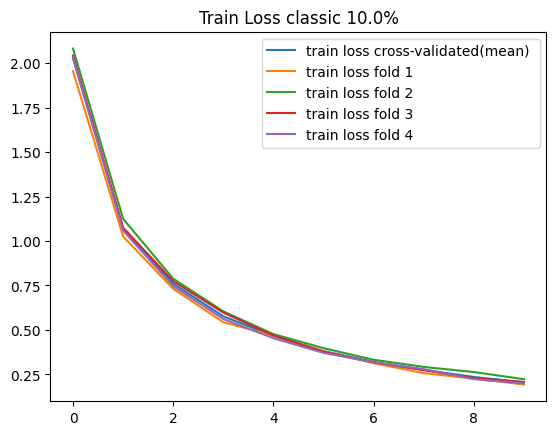

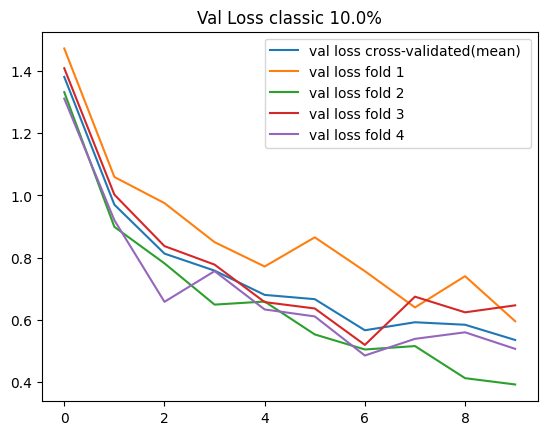

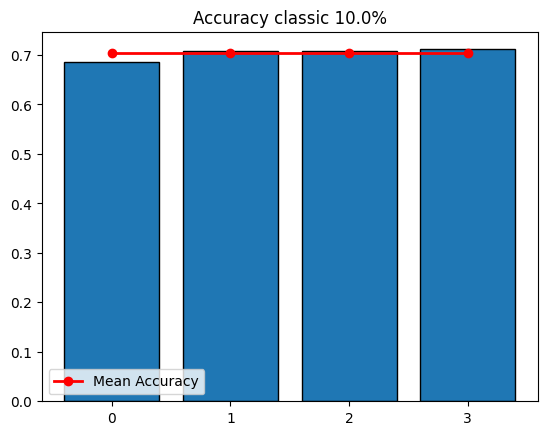

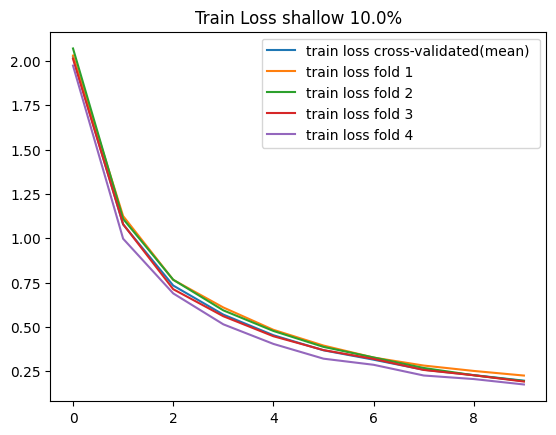

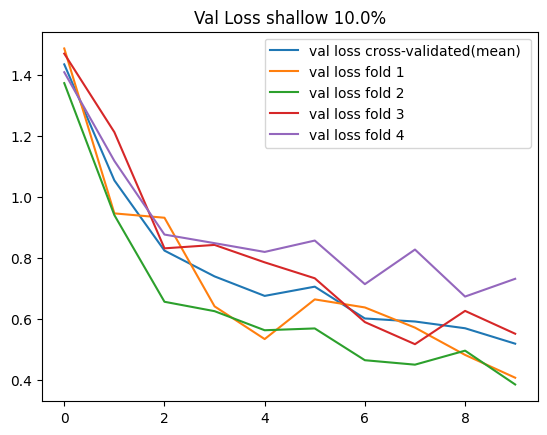

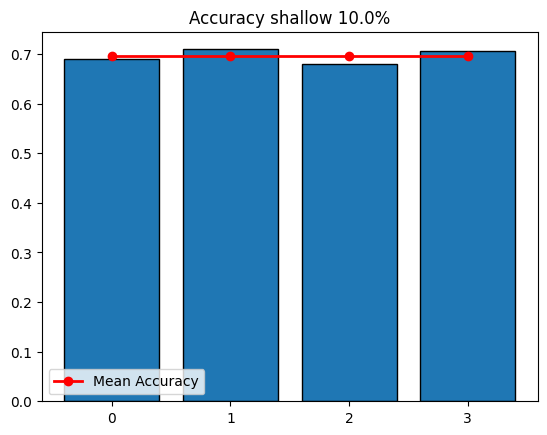

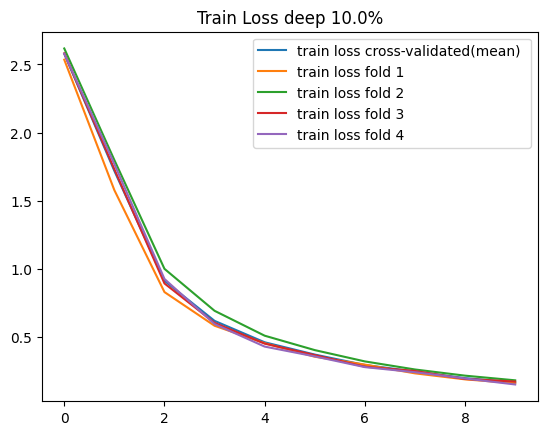

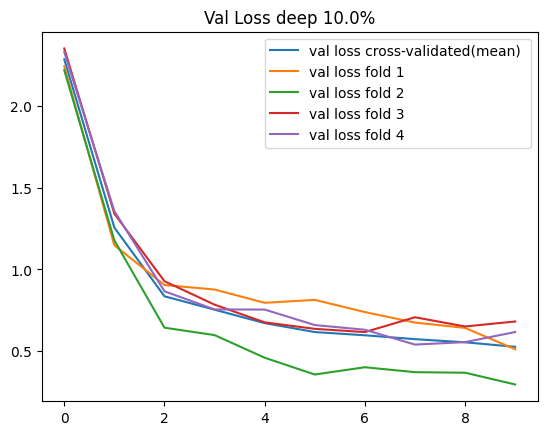

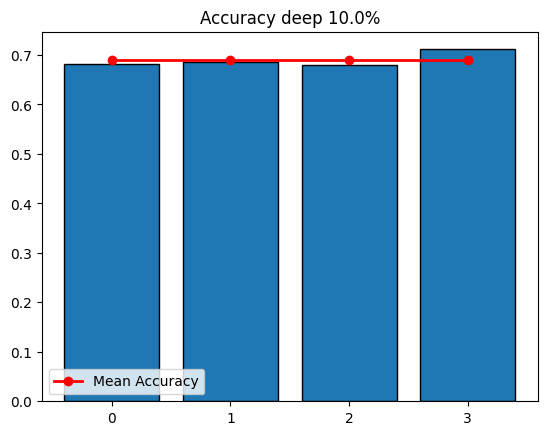

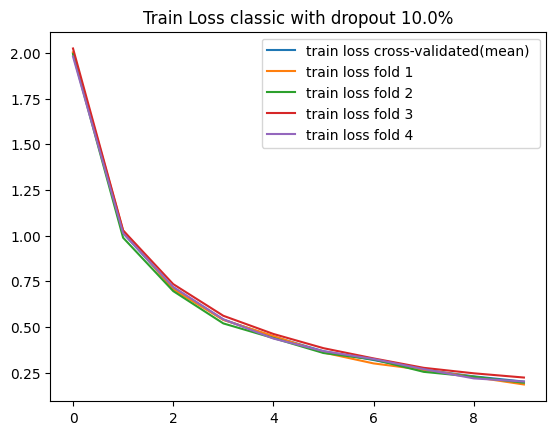

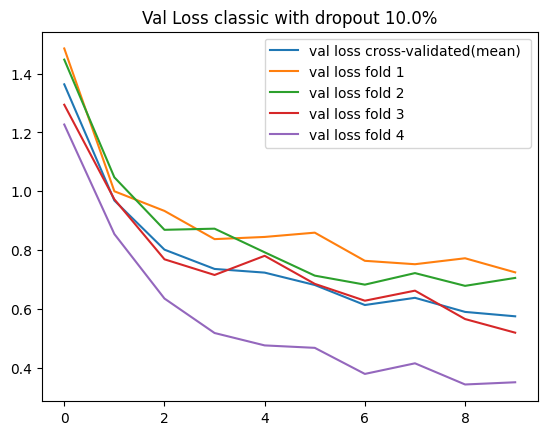

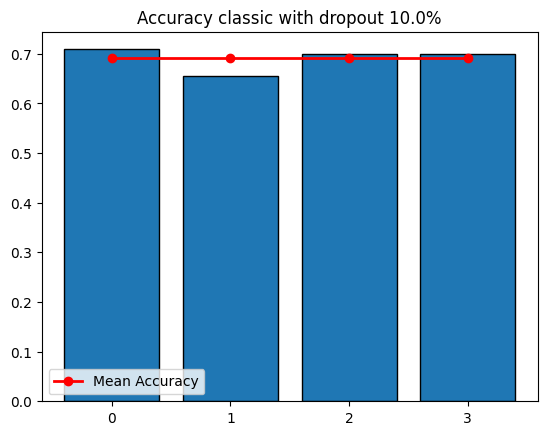

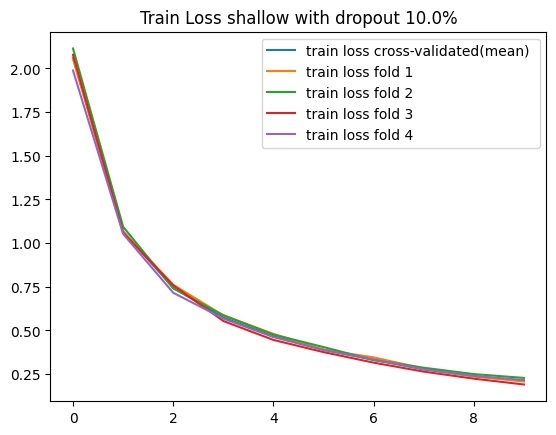

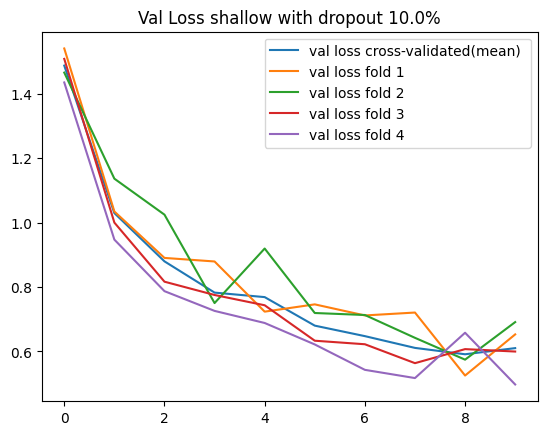

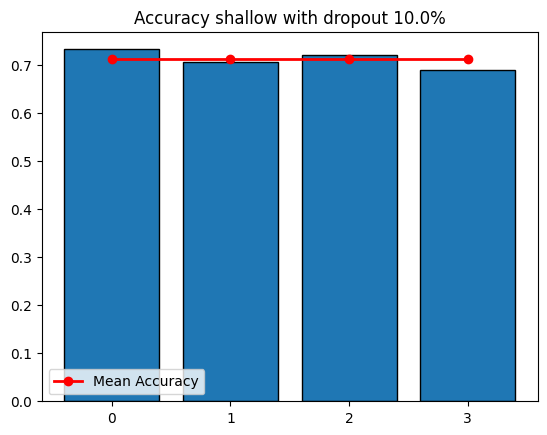

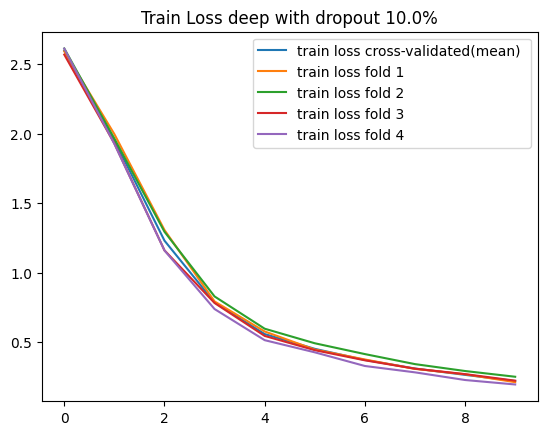

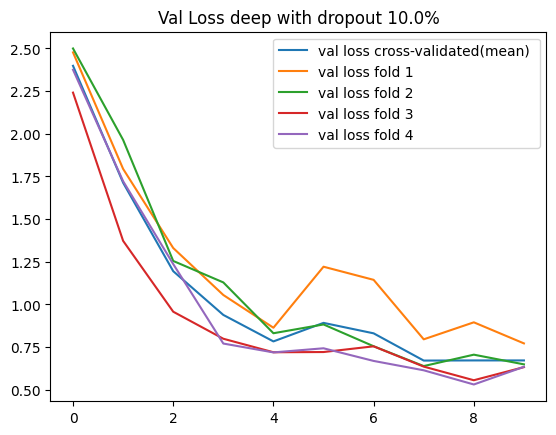

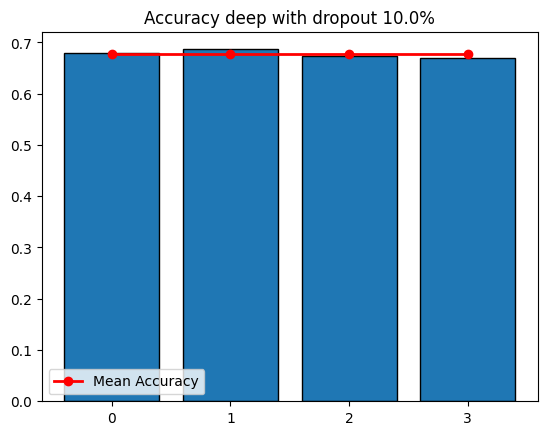

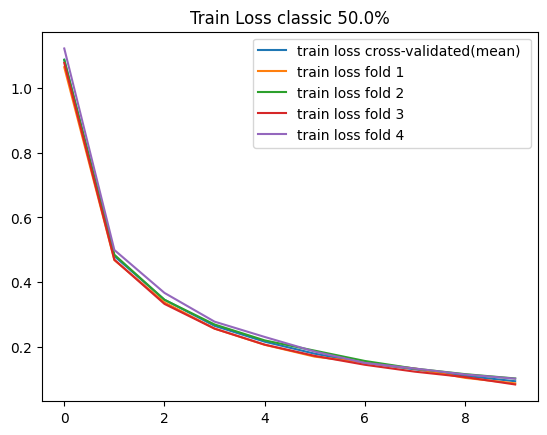

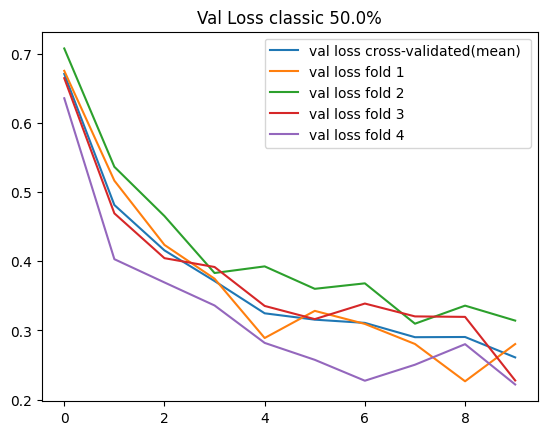

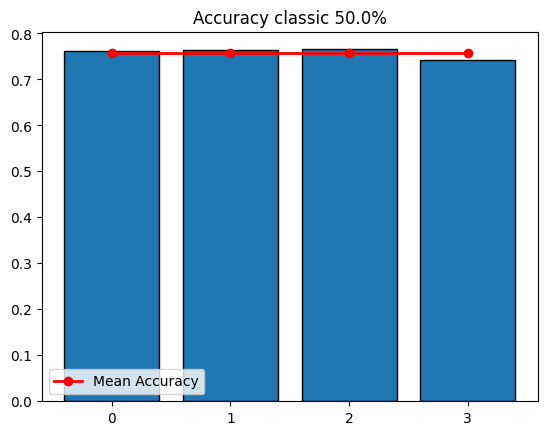

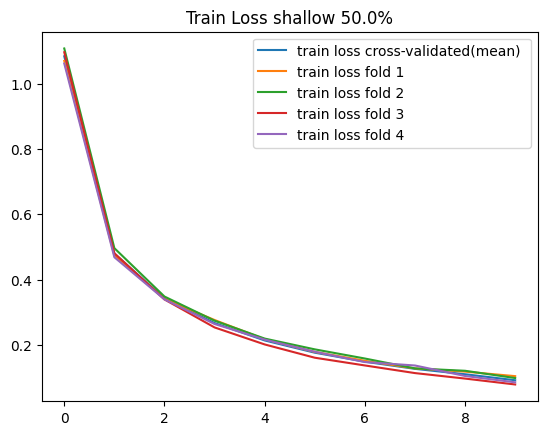

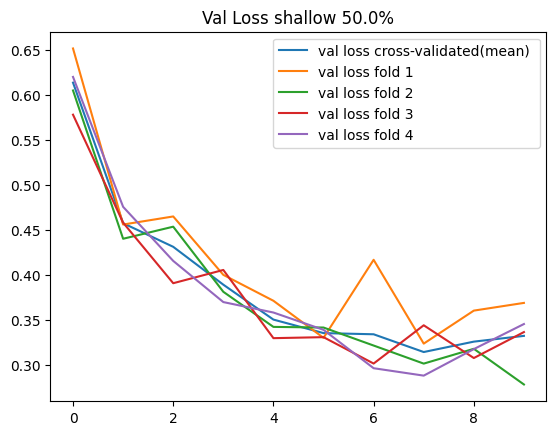

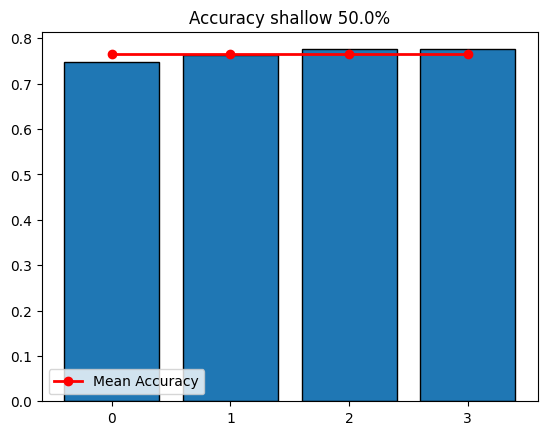

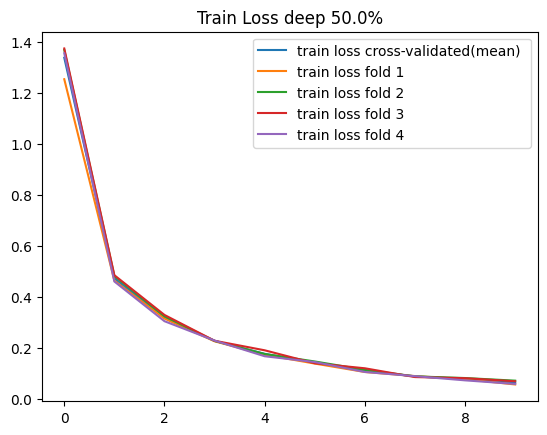

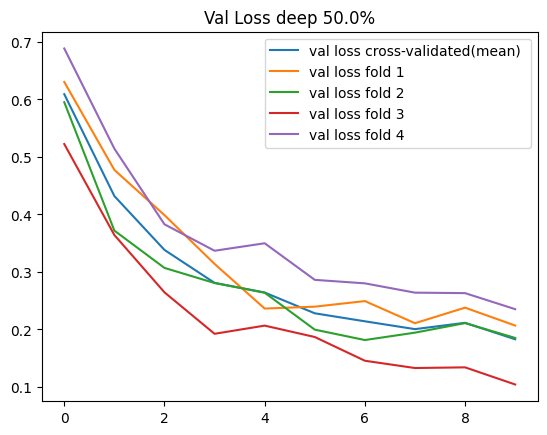

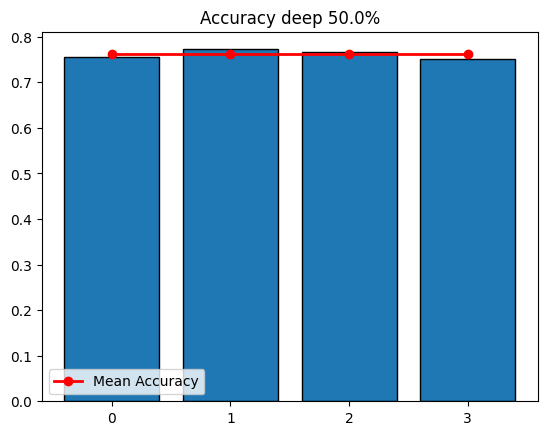

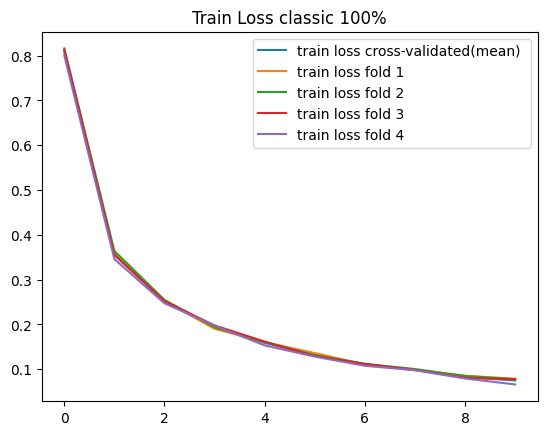

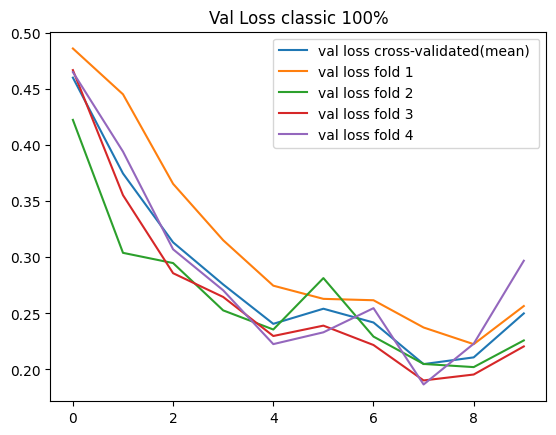

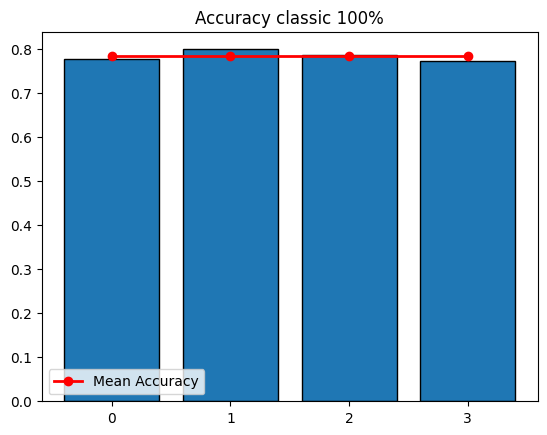

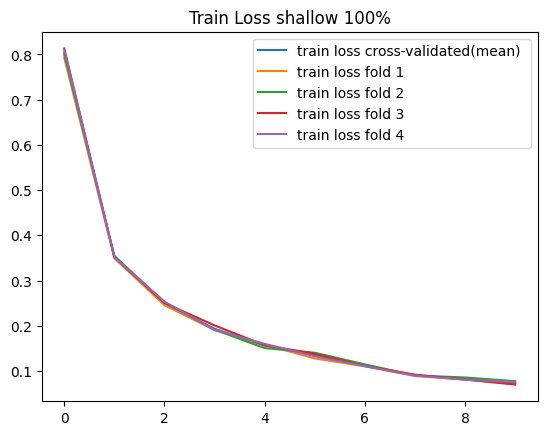

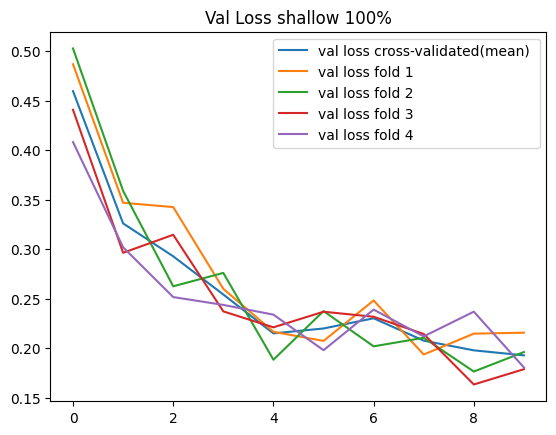

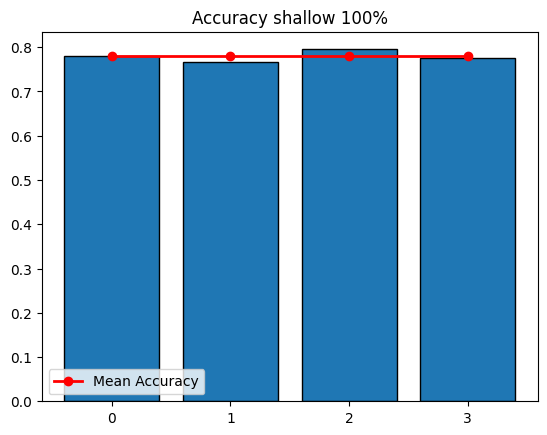

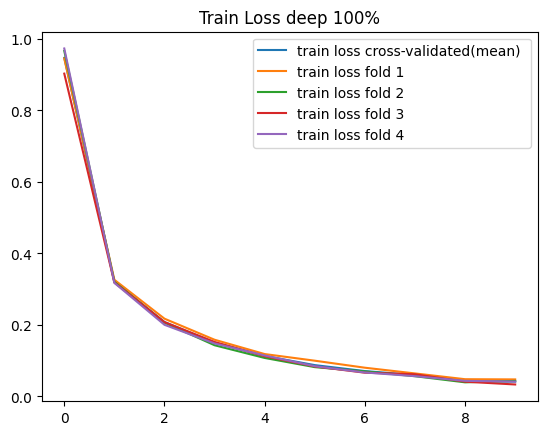

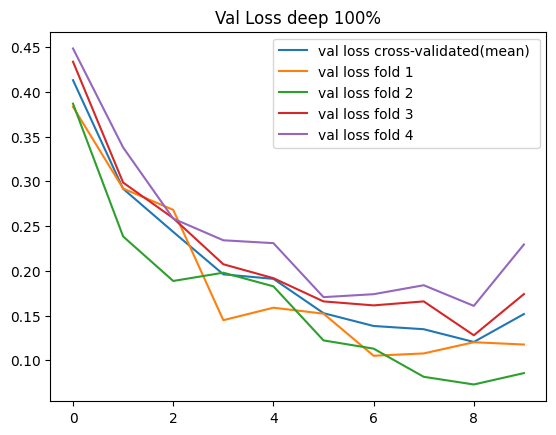

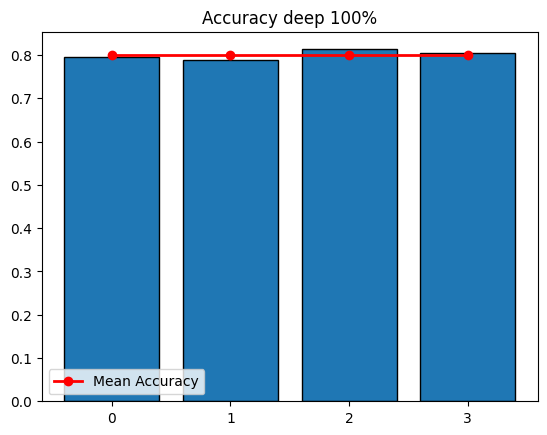

In [154]:
metric_files, file_names = load_metric_files(metric_path_var)

for (model_type, train_frac, dropout) in task_set:
    plot_train_loss(model_type, train_frac, metric_files, file_names, dropout, 4, 10)
    plot_val_loss(model_type, train_frac, metric_files, file_names, dropout, 4, 10)
    plot_accuracy(model_type, train_frac, metric_files, file_names, dropout, 4)

In [155]:
for (model_type, train_frac, dropout) in task_set:
    get_data(model_type, train_frac, metric_files, file_names, dropout, 4, 10)

dataset_10_only_head_raw_data
0.6857876712328768
0.708904109589041
0.7080479452054794
0.711472602739726
{'train_loss': 0.19311708434448613, 'val_loss': 0.5958169037476182}
{'train_loss': 0.22277674683696264, 'val_loss': 0.3927084915339947}
{'train_loss': 0.20702468874779614, 'val_loss': 0.6468546688556671}
{'train_loss': 0.19885737938782225, 'val_loss': 0.5071221478283405}
dataset_10_shallow_prompt_raw_data
0.6909246575342466
0.7097602739726028
0.6806506849315068
0.7063356164383562
{'train_loss': 0.22594360046862783, 'val_loss': 0.40805977024137974}
{'train_loss': 0.19484929234853812, 'val_loss': 0.3859323370270431}
{'train_loss': 0.19217408407334383, 'val_loss': 0.5520712966099381}
{'train_loss': 0.17564717104489153, 'val_loss': 0.7319529540836811}
dataset_10_deep_prompt_raw_data
0.6823630136986302
0.6866438356164384
0.6806506849315068
0.711472602739726
{'train_loss': 0.16268029525972805, 'val_loss': 0.5114043559879065}
{'train_loss': 0.18406525326820164, 'val_loss': 0.295826395042240

# Inference

## TUT17 Evaluation Dataset

In [156]:
# we MUST recreate the same dict of the training set for the test set
def create_dict_label_test(path):
    class_dict = {}
    label_index = 0
    with open(path, 'r') as file:
        for line in file:
            _, class_name,_ = line.strip().split()
            if class_name not in class_dict:
                class_dict[class_name] = label_index
                label_index += 1
    return class_dict

In [157]:
# from folder to PyTorch Dataset
class TUT17_Evaluation(Dataset):
    # audio_path: folder that contains all audio (no division)
    # split: tell which part of the dataset i'm using
    def __init__(self, audio_path, label_path):
        super().__init__()
        # store path audio and label
        self.label_path = label_path
        self.audio_path = audio_path

        # create dict label
        self.class_dict = create_dict_label_test(self.label_path)
        # retrive audio files
        audio_names = os.listdir(self.audio_path)
        self.data = audio_names
    
    # optional
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        audio_path = os.path.join(self.audio_path, self.data[idx])
        audio_name = audio_path.split('/')[-1][6:].replace('\\', '/').split('/')[-1]
        with open(self.label_path, "r") as f:
            while line := f.readline():
                if line.split('\t')[0][6:] == audio_name:
                    f.close()
                    audio, sample_rate = load_audio(audio_path)
                    return {'audio': audio, 'sample_rate': sample_rate, 'label': from_label_to_index(line.split('\t')[1], self.class_dict)}

## Test utilities

In [158]:
def inference(model_type, checkpoint_path, audio_path, label_path):
    # select device
    dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # instantiate criterion
    criterion = nn.CrossEntropyLoss()
    # instantiate model
    output_string = ""
    if model_type == 0:
        output_string = "Model AST Fine Tuning"
        model = AST_PromptTuning(prompt_type = None)
    elif model_type == 1:
        output_string = "Model AST Shallow Prompt"
        model = AST_PromptTuning(prompt_type = 'shallow')
    elif model_type == 2:
        output_string = "Model AST Deep Prompt"
        model = AST_PromptTuning(prompt_type = 'deep')
    else:
      raise ValueError('Invalid Model type')
    
    # instantiate optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    # instantiate dataset
    test_dataset = TUT17_Evaluation(audio_path, label_path)
    # instantiate data loaders
    test_loader = DataLoader(test_dataset, batch_size=4, num_workers=0, shuffle=True, drop_last=True)
    # load weights
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # inference
    accuracy = test(model, test_loader, criterion, dev)
    print(output_string + f'Accuracy{accuracy: .4f}')
    return accuracy

In [159]:
models_configuration_set = [{'inference': (0, 0.1, False), 'plotting': "Classic 10%"}, 
                            {'inference': (1, 0.1, False), 'plotting': "Shallow 10%"},
                            {'inference': (2, 0.1, False), 'plotting': "Deep 10%"},
                            {'inference': (0, 0.1, True), 'plotting': "Classic with dropout 10%"},
                            {'inference': (1, 0.1, True), 'plotting': "Shallow with dropout 10%"},
                            {'inference': (2, 0.1, True), 'plotting': "Deep with dropout 10%"},
                            {'inference': (0, 0.5, False), 'plotting': "Classic 50%"},
                            {'inference': (1, 0.5, False), 'plotting': "Shallow 50%"},
                            {'inference': (2, 0.5, False), 'plotting': "Deep 50%"},
                            {'inference': (0, 1, False), 'plotting': "Classic 100%"},
                            {'inference': (1, 1, False), 'plotting': "Shallow 100%"},
                            {'inference': (1, 1, False), 'plotting': "Deep 100%"}]

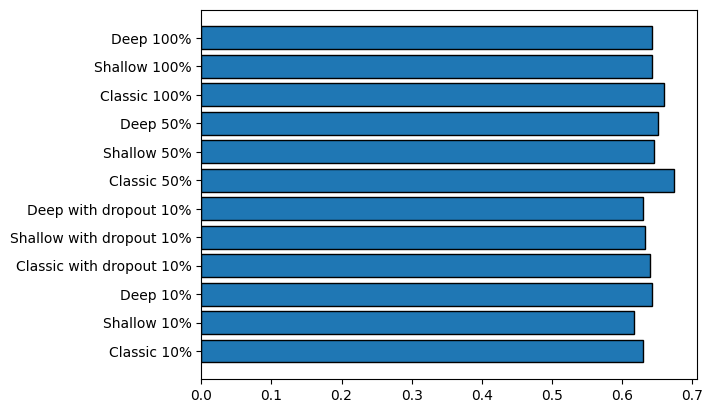

In [160]:
if not os.path.isfile(os.path.join(metric_path_var, "inference_accuracies.npy")):
    accuracies = []
    for item in models_configuration_set:
        (model_type, train_frac, dropout) = item['inference']
        # rebuild name file
        model_name = "model_type_" + str(model_type) + "_train_frac_" + str(train_frac * 100)
        # check if is used dropout during training
        if dropout == True:
            model_name += "_dropout"
        model_name += ".pth"
        accuracy = inference(model_type, os.path.join(checkpoint_path_var, model_name), inference_audio_path_var, inference_label_path_var)
        accuracies.append(accuracy)
    
    inference_dictionary = {
        'models_configuration_set': models_configuration_set,
        'accuracies': accuracies
    }
    np.save(os.path.join(metric_path_var, 'inference_accuracies.npy'), inference_dictionary)
    labels = [item['plotting'] for item in models_configuration_set]
    plt.barh(labels, accuracies, edgecolor = 'black')
    plt.title("Accuracy inference")
else:
    inference_dictionary = np.load(os.path.join(metric_path_var, 'inference_accuracies.npy'), allow_pickle = True).item()
    labels = [item['plotting'] for item in inference_dictionary['models_configuration_set']]
    plt.barh(labels, inference_dictionary['accuracies'], edgecolor = 'black')